# Combined SHAP probability waterfall for all teams

Create a plot that contains a SHAP probability waterfall for each team separately, but all on the same axis. There's not much room for bars so we plot lines and markers instead.

In [1]:
# Imports:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

## Setup

Change these patient details and highlighted team names.

In [2]:
# Select patient details
patient_dict = dict(
    arrival_to_scan_time=15,   # minutes
    infarction=1,              # 0=no, 1=yes
    stroke_severity=15,        # 0 to 42
    onset_time_precise=1,      # 0=no, 1=yes
    prior_disability=0,        # 0 to 6
    anticoag=0,                # 0=no, 1=yes
    onset_to_arrival_time=90,  # minutes
    onset_during_sleep=0,      # 0=no, 1=yes
    age=72.5                   # years
)

In [3]:
# Labels for teams generally:
plain_str = 'Non-benchmark'  # '-'
bench_str = 'Benchmark'  # 'Benchmark \U00002605'
highlight_and_bench_extra_str = ' \U00002605'

In [4]:
# Choose teams to highlight:
highlighted_teams_input = []  #'VUHVS8909F']
# Can specify colours in here for highlighted teams.
# If not specified, default matplotlib colours are used.
highlighted_teams_colours = {
    plain_str: 'grey',
    bench_str: 'navy',
    # 'VUHVS8909F': 'red'
    }

## Build the data arrays

In [5]:
# Import list of stroke team names from file:
stroke_teams_list = pd.read_csv('./synthetic/stroke_teams.csv')
stroke_teams_list = stroke_teams_list.values.ravel()

In [6]:
# Build the patient details into a 2D array
# with one row for each stroke team.

# First build a 2D array where each row is the patient details.
# Column headings:
headers = np.array([
    'Arrival-to-scan time',
    'Infarction',
    'Stroke severity',
    'Precise onset time',
    'Prior disability level',
    'Stroke team',
    'Use of AF anticoagulants',
    'Onset-to-arrival time',
    'Onset during sleep',
    'Age'
])

# One row of the array:
row = np.array([
    patient_dict['arrival_to_scan_time'],
    patient_dict['infarction'],
    patient_dict['stroke_severity'],
    patient_dict['onset_time_precise'],
    patient_dict['prior_disability'],
    'temp',  # Stroke team
    patient_dict['anticoag'],
    patient_dict['onset_to_arrival_time'],
    patient_dict['onset_during_sleep'],
    patient_dict['age']
    ], dtype=object)

# Repeat these row values for the number of stroke teams:
table = np.tile(row, len(stroke_teams_list))
# Reshape to a 2D array:
table = table.reshape(len(stroke_teams_list), len(headers))
# Update the "Stroke team" column with the names:
table[:, 5] = stroke_teams_list

# Turn this array into a DataFrame with labelled columns.
synthetic = pd.DataFrame(table, columns=headers)

In [7]:
# Make a copy of this data that is ready for the model.
# The same data except the Stroke Team column is one-hot-encoded.

# One-hot encode hospitals
# Keep copy of original, with 'Stroke team' not one-hot encoded
X = synthetic.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix='team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

# Store the column names:
headers_X = tuple(X.columns)

Extra formatting to show up benchmark and highlighted teams on the plot:

In [8]:
# Import benchmark data
benchmark_df = pd.read_csv('./synthetic/hospital_10k_thrombolysis.csv')
# Add an index row to rank the teams:
benchmark_df['Rank'] = \
    np.arange(1, len(benchmark_df['stroke_team'])+1)

# Make list of benchmark rank:
# (original data is sorted alphabetically by stroke team)
benchmark_rank_list = benchmark_df.sort_values('stroke_team')['Rank'].to_numpy()
# Indices of benchmark data at the moment:
inds_benchmark = np.where(benchmark_rank_list <= 30)[0]

In [9]:
# Highlighted list:
# Make a column of all teams where highlighted teams are listed by name
# and other teams are just called '-'.
highlighted_teams_list = np.array(
    ['-' for team in stroke_teams_list], dtype=object)

# Combo highlighted and benchmark:
hb_teams_list = np.array(
    [plain_str for team in stroke_teams_list], dtype=object)
# Mark the benchmark teams:
hb_teams_list[inds_benchmark] = bench_str
# Keep unique entries in here:
hb_teams_input = [plain_str, bench_str]

for team in highlighted_teams_input:
    ind_t = np.argwhere(stroke_teams_list == team)[0][0]
    # Update the highlighted teams list:
    highlighted_teams_list[ind_t] = team
    # Update the combo highlighted-benchmark list:
    if ind_t in inds_benchmark:
        # If it's a benchmark as well, add an extra bit:
        team = team + highlight_and_bench_extra_str
    hb_teams_list[ind_t] = team
    hb_teams_input.append(team)

## Predictions

In [10]:
# Load XGB Model
filename = ('./synthetic/model.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)

/home/anna/miniconda3/envs/shap/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [11]:
# Predict treatment
probs_list = model.predict_proba(X)[:, 1]

# Put everything into a DataFrame:
results = pd.DataFrame()
results['Stroke team'] = stroke_teams_list
results['Highlighted team'] = highlighted_teams_list
results['Benchmark rank'] = benchmark_rank_list
results['HB team'] = hb_teams_list
results['Probability'] = probs_list
results['Probability_perc'] = probs_list*100.0
results['Thrombolyse'] = probs_list >= 0.5
results['Index'] = np.arange(len(results))

sorted_results = results.\
    sort_values('Probability', ascending=False)

# Add column of sorted index:
sorted_results['Sorted rank'] = np.arange(1, len(results) + 1)

# Add column of str to print when thrombolysed or not
thrombolyse_str = np.full(len(sorted_results), 'No ')
thrombolyse_str[np.where(sorted_results['Thrombolyse'])] = 'Yes'
sorted_results['Thrombolyse_str'] = thrombolyse_str


## SHAP

In [12]:
# Load SHAP explainers
filename = ('./synthetic/shap_explainer.p')
with open(filename, 'rb') as filehandler:
    explainer = pickle.load(filehandler)

filename = ('./synthetic/shap_explainer_probability.p')
with open(filename, 'rb') as filehandler:
    explainer_probability = pickle.load(filehandler)

In [13]:
# Get Shapley values along with base and features
shap_values_probability_extended = explainer_probability(X)

# Shap values exist for each classification in a Tree
shap_values_probability = shap_values_probability_extended.values

In [14]:
# Find the starting probability:
start_prob = shap_values_probability_extended[0].base_values
start_prob_perc = 100.0 * start_prob

start_prob

0.2995270168908044

## Sort data for plotting

In [15]:
# Re-name all shap probability shifts:
grid = np.transpose(shap_values_probability)

# Expect most of the mismatched one-hot-encoded hospitals to make
# only a tiny contribution to the SHAP. Moosh them down into one
# column instead.

# Have 9 features other than teams. Index 9 is the first team.
ind_first_team = 9
# This many stroke teams:
n_teams = shap_values_probability.shape[0]

# Make a new grid of size (number of non-team features) + 2,
# where the two extras are for "this team only" and "all other teams".
grid_cat = np.zeros((ind_first_team + 1, n_teams))
# Copy over most of the values:
grid_cat[:ind_first_team, :] = grid[:ind_first_team, :]

# For the remaining column, loop over to pick out the value:
for i, sorted_ind in enumerate(sorted_results['Index']):
    row = i + ind_first_team
    # Combine all of the one-hot team values into here:
    grid_cat[ind_first_team, i] = np.sum(grid[ind_first_team:, i])

    # ... or use the following block to separate out the value for
    # this team from the values of all the other teams.
    # # Pick out the value we want:
    # value_of_matching_stroke_team = grid[row, i]
    # # Add the wanted value to the new grid:
    # grid_cat[ind_first_team, i] = value_of_matching_stroke_team
    # # Take the sum of all of the team values:
    # value_of_merged_stroke_teams = np.sum(grid[ind_first_team:, i])
    # # Subtract the value we want:
    # value_of_merged_stroke_teams -= value_of_matching_stroke_team
    # # And store this as a merged "all other teams" value:
    # grid_cat[ind_first_team+1, i] = value_of_merged_stroke_teams

# Multiply values by 100 to get probability in percent:
grid_cat *= 100.0

# Sort the teams into the same order as sorted_results:
grid_cat_sorted = grid_cat[:, sorted_results['Index']]

# Keep a copy of the new column headings with condensed teams
headers_waterfall = np.append(headers_X[:9], 'Stroke team attended')
# headers_waterfall = np.append(headers_waterfall, 'Stroke teams not attended')

In [16]:
# Pull out the feature values:
patient_data_waterfall = X.iloc[0][:9].to_numpy()
# Add empty value for stroke team attended:
patient_data_waterfall = np.append(patient_data_waterfall, '')

# Find which values are 0/1 choice and can be changed to no/yes:
features_yn = [
    'Infarction',
    'Precise onset time',
    'Use of AF anticoagulants',
    'Onset during sleep',
]
for feature in features_yn:
    i = np.where(headers_waterfall == feature)[0]
    patient_data_waterfall[i] = 'Yes' if patient_data_waterfall[i] > 0 else 'No'


To access all of the shifts for feature 0:
`grid_cat_sorted[0, :]`

To access all of the shifts for team 0:
`grid_cat_sorted[:, 0]`

In [17]:
# Sort the grids by increasing standard deviation in the shifts for each feature.
grid_waterfall = np.copy(grid_cat_sorted)
# Sort the grid in order of increasing standard deviation:
inds_std = np.argsort(np.std(grid_waterfall, axis=1))
grid_waterfall = grid_waterfall[inds_std, :]
features_waterfall = headers_waterfall[inds_std]
patient_data_waterfall = patient_data_waterfall[inds_std]

In [18]:
# Add a row for the starting probability:
grid_waterfall = np.vstack(
    (np.zeros(grid_waterfall.shape[1]), grid_waterfall))
# Make a cumulative probability line for each team:
grid_waterfall_cumsum = np.cumsum(grid_waterfall, axis=0)
# Add the starting probability to all values:
grid_waterfall_cumsum += start_prob_perc
# Keep final probabilities separate:
final_probs_list = grid_waterfall_cumsum[-1, :]
# Feature names:
features_waterfall = np.append('Base probability', features_waterfall)
features_waterfall = np.append(features_waterfall, 'Final probability')
# Feature values:
patient_data_waterfall = np.append('', patient_data_waterfall)
patient_data_waterfall = np.append(patient_data_waterfall, '')

In [19]:
# Combine feature names and values for tick labels:
# (same idea as the original shap red/blue waterfall plot)
features_with_values_waterfall = []
for i, value in enumerate(patient_data_waterfall):
    if value != '':
        value = str(value)
        if 'rrival' in features_waterfall[i]:
            # Onset to arrival or arrival to scan time:
            value += ' mins'
        elif 'Age' in features_waterfall[i]:
            value += ' years'
        # If it's not a dummy feature value, add an equals sign:
        value += ' = '
    # Combine the value and the feature name:
    feature_with_value = value + features_waterfall[i]
    features_with_values_waterfall.append(feature_with_value)

## Plot the combined waterfall

### Version 1: Box plot

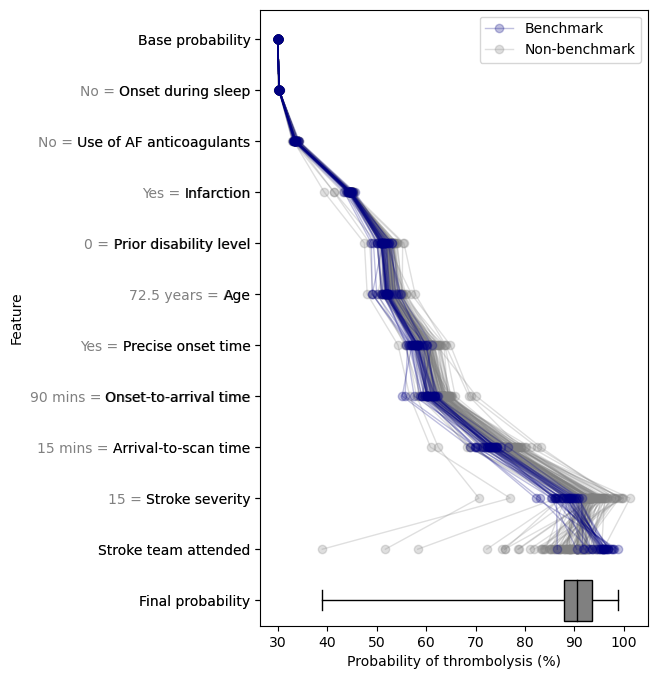

In [20]:
y_vals = np.arange(0, -len(features_waterfall), -1)

# Only draw the plain and benchmark lines in the legend once.
# Use these to keep track of whether they've been drawn or not:
drawn_blank_legend_line = 0
drawn_bench_legend_line = 0

fig, ax = plt.subplots(figsize=(5,8))
for i, team in enumerate(sorted_results['Stroke team']):
    if team == sorted_results['Highlighted team'].iloc[i]:
        # Highlighted team
        legend_name = sorted_results['HB team'].iloc[i]
        opacity = 1.0
        width = 2.0
        zorder = 3  # Draw at the top
    else:
        if sorted_results['HB team'].iloc[i] == plain_str: # '-':
            # Plain team
            zorder = 1  # Draw on the bottom
            if drawn_blank_legend_line > 0:
                # Don't put this in the legend
                legend_name = None
            else:
                # Put this in the legend
                legend_name = plain_str  # '-'
                drawn_blank_legend_line += 1
        else:
            # Benchmark team
            zorder = 2  # Draw in the middle
            if drawn_bench_legend_line > 0:
                # Don't put this in the legend
                legend_name = None
            else:
                # Put this in the legend
                legend_name = bench_str # sorted_results['HB team'].iloc[i]
                drawn_bench_legend_line += 1
        opacity = 0.25
        width = 1.0
    try:
        colour = highlighted_teams_colours[sorted_results['HB team'].iloc[i]]
    except KeyError:
        colour = None

    # Plot
    ax.plot(grid_waterfall_cumsum[:, i], y_vals[:-1], marker='o', 
            alpha=opacity, color=colour, linewidth=width, 
            label=legend_name, zorder=zorder)

# Box plot for the final probabilities
b_dict = ax.boxplot(
    final_probs_list,
    whis=[0, 100],                # Whiskers extend from 0th to 100th percentile
    vert=False,                   # Horizontal box plot
    positions=[y_vals[-1]],       # Position on y-axis
    widths=0.8,                   # Height of the box
    medianprops=dict(color='k'),  # Change colour of median line in box
    patch_artist=True,            # Necessary for changing colour
)
# Update box colour:
b_dict['boxes'][0].set_facecolor('grey')

# Axis formatting:
# Make twice as many y tick locations as we need, slightly offset:
yticks = np.append(y_vals, y_vals + 1e-7)
# Give the first half of the ticks the full labels,
# and the second half just the feature names:
yticklabels = np.append(features_with_values_waterfall, features_waterfall)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
# Change the colour of the first half of the drawn ticks:
yticklabels_drawn = plt.gca().get_yticklabels()
for i in range(len(y_vals)):
    yticklabels_drawn[i].set_color('grey')

ax.set_ylabel('Feature')
ax.set_xlabel('Probability of thrombolysis (%)')

ax.legend()

plt.savefig('shap_waterfall_with_box.png', bbox_inches='tight')
plt.show()

### Version 2: Violin plot

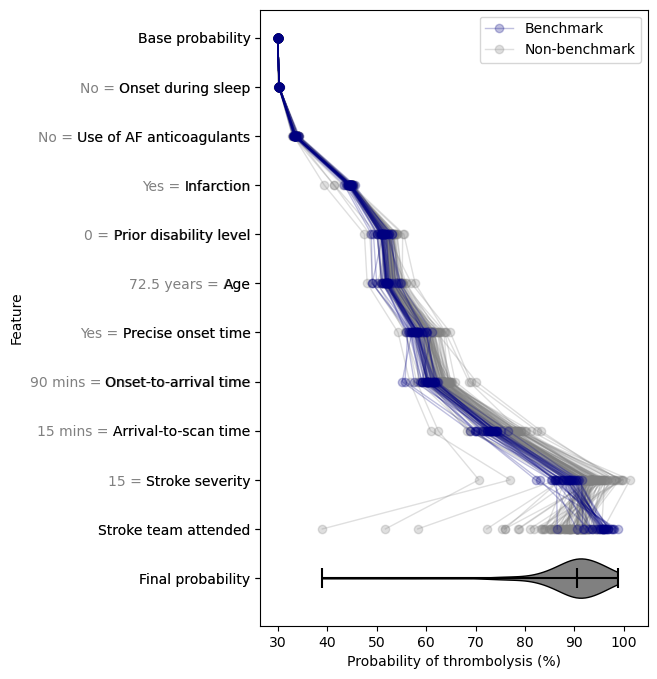

In [21]:
y_vals = np.arange(0, -len(features_waterfall), -1)

# Only draw the plain and benchmark lines in the legend once.
# Use these to keep track of whether they've been drawn or not:
drawn_blank_legend_line = 0
drawn_bench_legend_line = 0

fig, ax = plt.subplots(figsize=(5,8))
for i, team in enumerate(sorted_results['Stroke team']):
    if team == sorted_results['Highlighted team'].iloc[i]:
        # Highlighted team
        legend_name = sorted_results['HB team'].iloc[i]
        opacity = 1.0
        width = 2.0
        zorder = 3  # Draw at the top
    else:
        if sorted_results['HB team'].iloc[i] == plain_str:
            # Plain team
            zorder = 1  # Draw on the bottom
            if drawn_blank_legend_line > 0:
                # Don't put this in the legend
                legend_name = None
            else:
                # Put this in the legend
                legend_name = plain_str
                drawn_blank_legend_line += 1
        else:
            # Benchmark team
            zorder = 2  # Draw in the middle
            if drawn_bench_legend_line > 0:
                # Don't put this in the legend
                legend_name = None
            else:
                # Put this in the legend
                legend_name = bench_str  #sorted_results['HB team'].iloc[i]
                drawn_bench_legend_line += 1
        opacity = 0.25
        width = 1.0
    try:
        colour = highlighted_teams_colours[sorted_results['HB team'].iloc[i]]
    except KeyError:
        colour = None

    # Plot
    ax.plot(grid_waterfall_cumsum[:, i], y_vals[:-1], marker='o', 
            alpha=opacity, color=colour, linewidth=width, 
            label=legend_name, zorder=zorder)

# Violin plot
v_dict = ax.violinplot(
    final_probs_list,
    vert=False,                   # Horizontal box plot
    positions=[y_vals[-1]],       # Position on y-axis
    widths=0.8,                   # Max height of the violin
    showextrema=True,             # Add whiskers at ends
    showmedians=True              # Add whisker at median
)
# Update style:
# Reset default transparency 
# (including filled shape outline transparency)
v_dict['bodies'][0].set_alpha(1.0)
# Colour of the filled shape:
v_dict['bodies'][0].set_facecolor('grey')
v_dict['bodies'][0].set_edgecolor('k')
# Colour of the lines:
linecollections = ['cmins', 'cmaxes', 'cbars', 'cmedians']
for lc in linecollections:
    v_dict[lc].set_edgecolor('k')


# Axis formatting:
# Make twice as many y tick locations as we need, slightly offset:
yticks = np.append(y_vals, y_vals + 1e-7)
# Give the first half of the ticks the full labels,
# and the second half just the feature names:
yticklabels = np.append(features_with_values_waterfall, features_waterfall)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
# Change the colour of the first half of the drawn ticks:
yticklabels_drawn = plt.gca().get_yticklabels()
for i in range(len(y_vals)):
    yticklabels_drawn[i].set_color('grey')

ax.set_ylabel('Feature')
ax.set_xlabel('Probability of thrombolysis (%)')

ax.legend()

plt.savefig('shap_waterfall_with_violin.png', bbox_inches='tight')
plt.show()